## Imports

In [1]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Retrieve Images

In [2]:
def getImagesFromDirectory(directory):
    images = []   
    for imageFile in os.listdir(directory):
        images.append(mpimg.imread(directory + '/' + imageFile))   
    return images

def displayImages(images):
    for image in images:
        displayImage(image)

def displayImage(image):
    plt.figure()
    if len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)

In [62]:
calibrationImages = getImagesFromDirectory('camera_cal')
testImages = getImagesFromDirectory('test_images')

In [4]:
#displayImages(calibrationImages)
#displayImages(testImages)

## Calibrate Camera

In [5]:
# get the chessboard corners

singleObjectPoints = np.zeros((6*9,3), np.float32)
singleObjectPoints[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

objectPoints = []
imagePoints = []
boardsWithPoints = []

for image in calibrationImages:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    if ret == True:
        imagePoints.append(corners)
        objectPoints.append(singleObjectPoints)
        #boardsWithPoints.append(cv2.drawChessboardCorners(image, (9,6), corners, ret))
        
#displayImages(boardsWithPoints)

In [6]:
# use the chessboard corners to calculate the calibration matrix

shape = calibrationImages[0].shape
shape = (shape[1], shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectPoints, imagePoints, shape, None, None)

def undistortImage(image, mtx, dist):
    return cv2.undistort(image, mtx, dist, None, mtx)


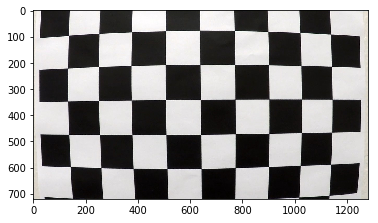

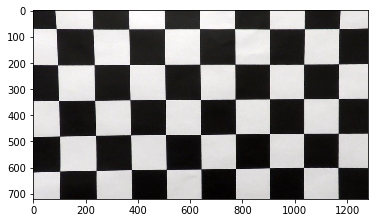

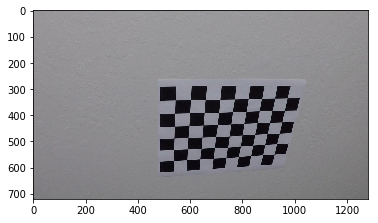

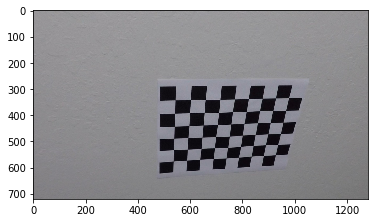

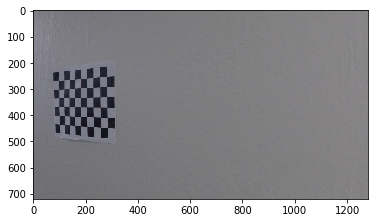

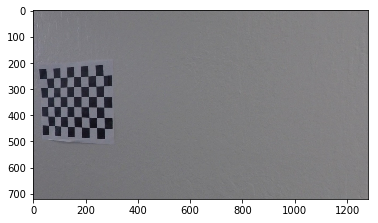

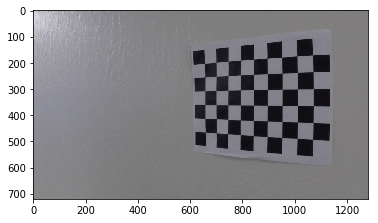

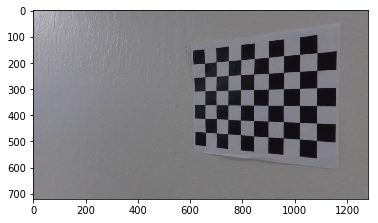

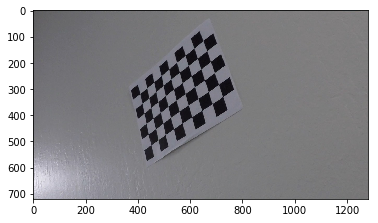

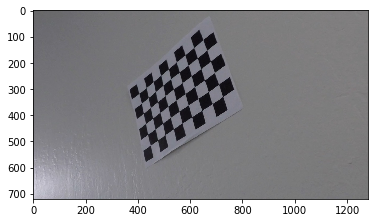

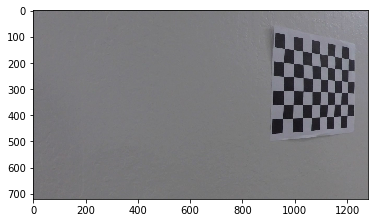

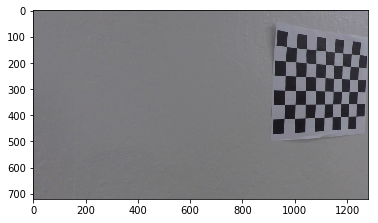

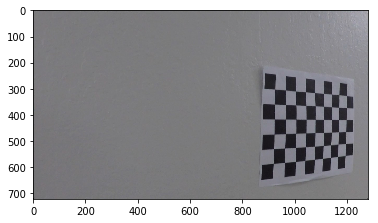

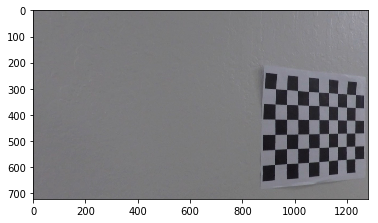

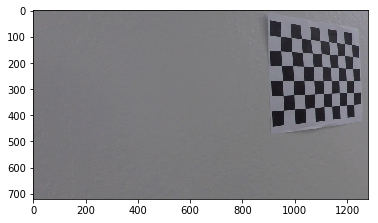

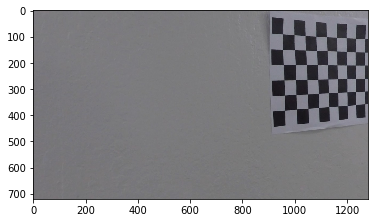

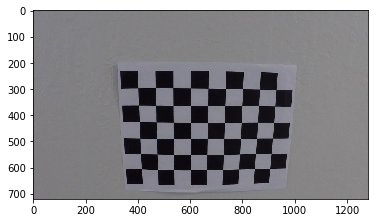

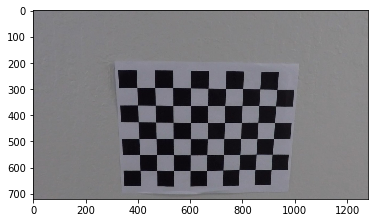

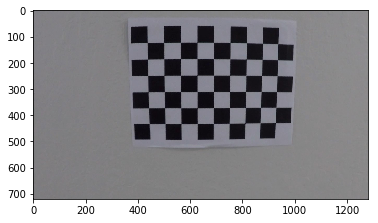

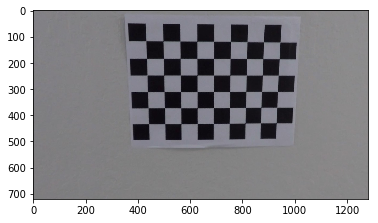

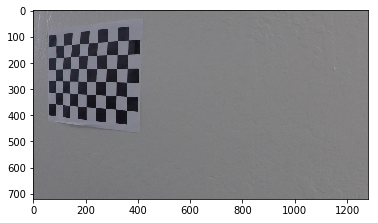

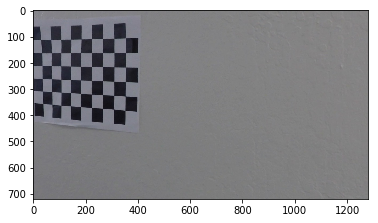

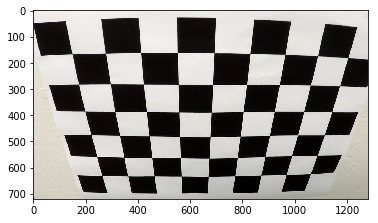

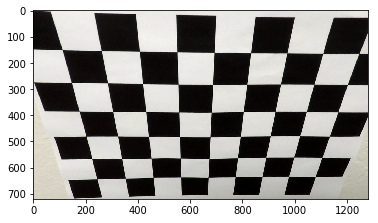

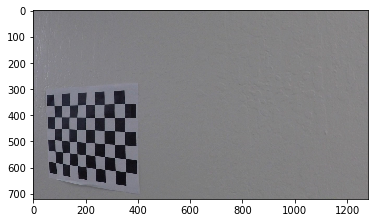

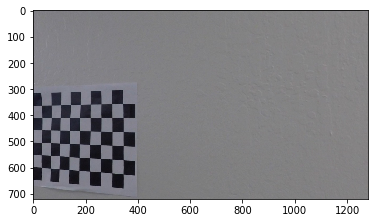

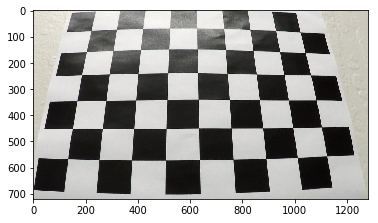

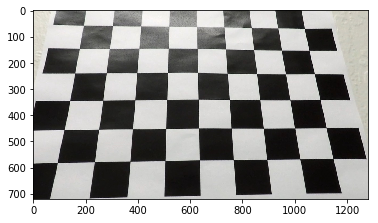

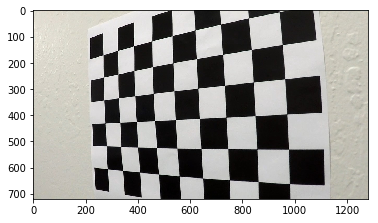

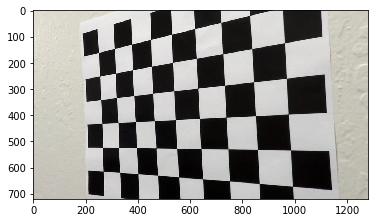

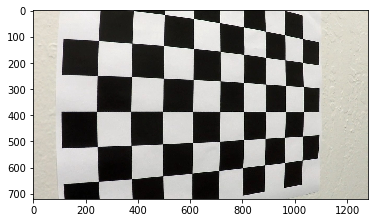

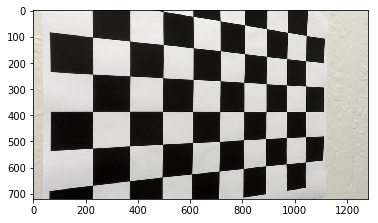

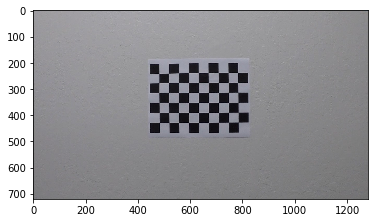

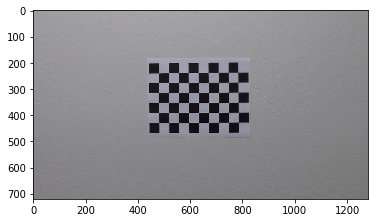

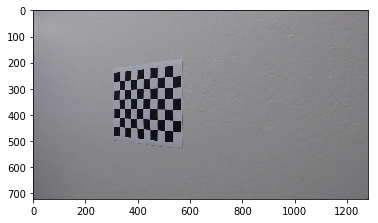

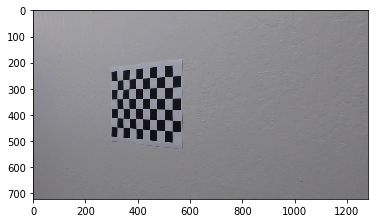

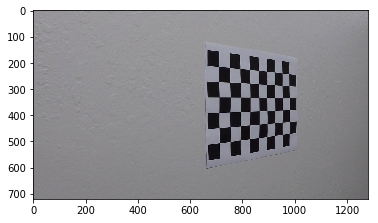

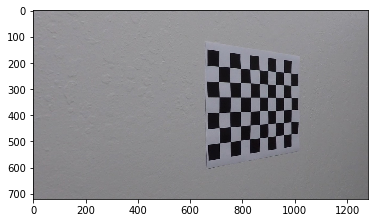

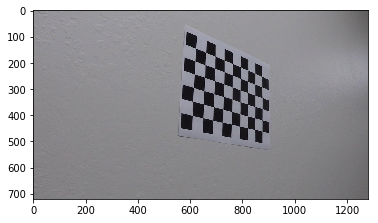

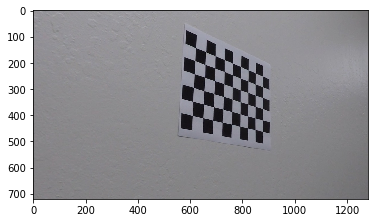

In [7]:
for image in calibrationImages:
    displayImage(image)
    displayImage(undistortImage(image, mtx, dist))

## Pipeline

In [223]:
# not part of the pipeline, but useful for debugging

def displayCombinedBinary(image1, image2):
    color_binary = np.dstack(( np.zeros_like(image1), image1, image2)) * 255
    displayImage(color_binary)
    
def printText(image, text, yPosition):
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (10,yPosition)
    fontScale              = 2
    fontColor              = (255,255,255)
    lineType               = 3

    cv2.putText(image, text, bottomLeftCornerOfText, font, fontScale, fontColor, lineType)

### Gradient and S channel thresholding

In [9]:
def sobel(image, axis, threshold):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    #gray = image[:,:,0]
    if axis == "y":
        x=0
        y=1
    else:
        x=1
        y=0
    sobel = cv2.Sobel(gray, cv2.CV_64F, x, y)
    abs_sobel = np.absolute(sobel)
    scaled_sobel=np.uint8(255*abs_sobel/np.max(abs_sobel))
    return thresholdArray(scaled_sobel, threshold)
    
def thresholdArray(array, threshold):
    outputArray = np.zeros_like(array)
    outputArray[(array >= threshold[0]) & (array <= threshold[1])] = 1
    return outputArray

def s_channel(image, threshold):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    return thresholdArray(s_channel, threshold)
    
def combineBinaries(image1, image2):
    combined = np.zeros_like(image1)
    combined[(image1 == 1) | (image2 == 1)] = 1
    return combined
    
def thresholdImage(image, debug = False):
    sobelX = sobel(image, "x", (30,100))
    s = s_channel(image, (170, 255))
    if debug:
        displayCombinedBinary(sobelX, s)
    outputImage = combineBinaries(sobelX, s)
    return outputImage

### Perspective Transform

In [10]:
def getPerspectiveMatrices():
    source = np.float32([
        (257, 688),   #bottom left
        (595, 451),   #top left
        (683, 451),   #top right
        (1049, 688)]) #bottom right
    x_offset = 300
    image_size = (image.shape[1], image.shape[0])
    destination = np.float32([ 
        [x_offset, image_size[1]], #bottom left
        [x_offset, 0],   #top left
        [image_size[0]-x_offset, 0], #top right
        [image_size[0]-x_offset, image_size[1]] #bottom right
        ])
    forwardMatrix = cv2.getPerspectiveTransform(source, destination)
    inverseMatrix = cv2.getPerspectiveTransform(destination, source)
    return (forwardMatrix, inverseMatrix)

def shiftPerspective(image, matrix):
    image_size = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(image, matrix, image_size, flags=cv2.INTER_LINEAR)
    return warped

## Identify Lines

### Define Line Class

In [196]:
class Line():
    def __init__(self, side):
        self.detectedInPrevFrame = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        if side == 'left':
            self.left = True
        if side == 'right':
            self.left = False
        
        self.windows = []
    
    def findLine(self, image):
        histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
        
        midpoint = np.int(histogram.shape[0]//2)
        if self.left:
            x_base = np.argmax(histogram[:midpoint])
        else:
            x_base = np.argmax(histogram[midpoint:]) + midpoint
        
        num_windows = 9
        window_height = np.int(image.shape[0]//num_windows)
        
        nonzero = image.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        x_current = x_base
        margin = 100
        minpix = 50
        
        lane_pixel_indices = []
        
        for window in range(num_windows):
            # Identify window boundaries in x and y
            win_y_low = image.shape[0] - (window+1)*window_height
            win_y_high = image.shape[0] - window*window_height
            win_x_low = x_current - margin
            win_x_high = x_current + margin
            
            self.windows.append([(win_x_low, win_y_low),(win_x_high, win_y_high)])
            
            # Identify the nonzero pixels in x and y within the window
            good_pixels = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_x_low) &  (nonzerox < win_x_high)).nonzero()[0]
            
            # Append these indices to the lists
            lane_pixel_indices.append(good_pixels)
            
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_pixels) > minpix:
                x_current = np.int(np.mean(nonzerox[good_pixels]))
        
        lane_pixel_indices = np.concatenate(lane_pixel_indices)
        self.allx = nonzerox[lane_pixel_indices]
        self.ally = nonzeroy[lane_pixel_indices]
        self.current_fit = np.polyfit(self.ally, self.allx, 2)
        
        return
        
    def drawLine(self, image):
        if len(image.shape) == 2:
            out_img = np.dstack((image, image, image))*255
        else:
            out_img = image
        
        for window in self.windows:
            cv2.rectangle(out_img, window[0], window[1], (0,255,0), 2)
            
        # color points on the output image
        if self.left:
            color = [255, 0, 0]
        else:
            color = [0, 0, 255]
        out_img[self.ally, self.allx] = color

        # plot the fits on the output image
        points = []
        ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
        fitx = self.current_fit[0]*ploty**2 + self.current_fit[1]*ploty + self.current_fit[2]

        for i in range(len(ploty)):
            points.append([int(round(fitx[i])),int(ploty[i])])

        cv2.polylines(out_img, np.int32([points]), False, [255, 255, 255])
        
        return out_img

In [198]:
def identifyLines(image):
    leftLine = Line('left')
    rightLine = Line('right')
    
    leftLine.findLine(image)
    rightLine.findLine(image)
    
    out_image = rightLine.drawLine(image)
    out_image = leftLine.drawLine(out_image)
    
    return out_image, leftLine, rightLine

In [206]:
def showLineOutput(image, out_img, left_fit, leftx, lefty, right_fit, rightx, righty):
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
def addLinesToOriginalImage(image, leftLine, rightLine):
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
    left_fit = leftLine.current_fit
    right_fit = rightLine.current_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    points = []
    for i in range(len(ploty)):
        points.append([int(round(left_fitx[i])),int(ploty[i])])
    for i in range(len(ploty)-1, -1, -1):
        points.append([int(round(right_fitx[i])),int(ploty[i])])

    lanes = np.zeros_like(image)
    cv2.fillConvexPoly(lanes, np.array(points), 255)
    lanes = shiftPerspective(lanes,inverseMatrix)
    
    return cv2.addWeighted(image, .8, lanes, .2, 0)

## Calculate curvature

In [204]:
def calcCurvature(line):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(line.ally*ym_per_pix, line.allx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    y_eval = image.shape[0]-1
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    
    return curverad

### Pipeline definition

In [221]:
perspectiveMatrix, inverseMatrix = getPerspectiveMatrices()

def imagePipeline(image, debug = False):
    outputImage = undistortImage(image, mtx, dist)
    if debug:
        displayImage(outputImage)
    
    outputImage = thresholdImage(outputImage)
    if debug:
        displayImage(outputImage)
    
    outputImage = shiftPerspective(outputImage, perspectiveMatrix)
    if debug:
        displayImage(outputImage)
        
    outputImage, leftLine, rightLine = identifyLines(outputImage)
    if debug:
        displayImage(outputImage)
        
    leftCurve = calcCurvature(leftLine)
    rightCurve = calcCurvature(rightLine)
    
    outputImage = addLinesToOriginalImage(image, leftLine, rightLine)
    printText(outputImage, 'left: ' + str(round(leftCurve)), 70)
    printText(outputImage, 'right: ' + str(round(rightCurve)), 130)
    
    if len(outputImage.shape) == 2:
        # if it's gray, make it a 3 channel image for the video formatting
        outputImage = np.dstack((outputImage, outputImage, outputImage)) * 255
        
    return outputImage


## Test Images

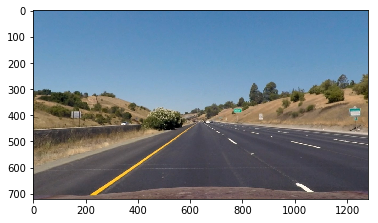

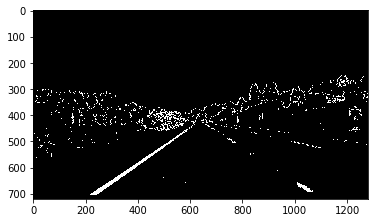

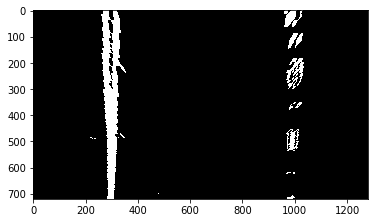

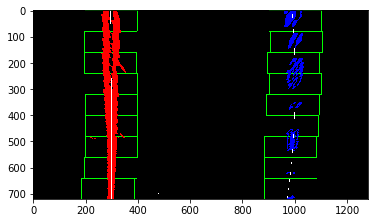

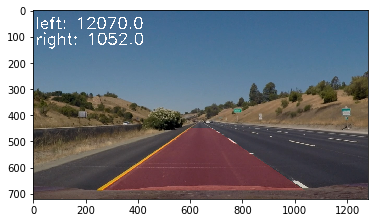

In [220]:
testImages = getImagesFromDirectory('test_images')
image = testImages[0]
displayImage(imagePipeline(image, debug=True))

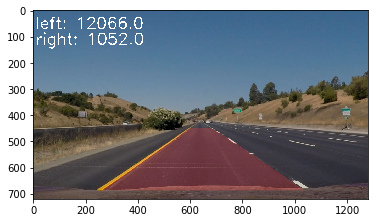

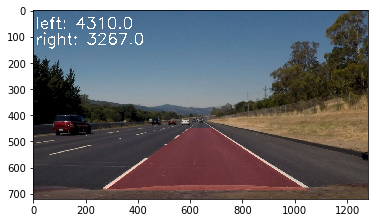

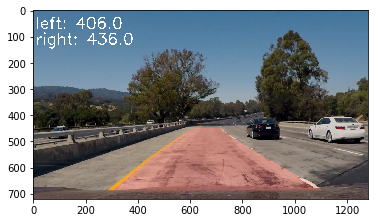

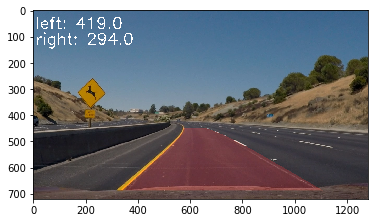

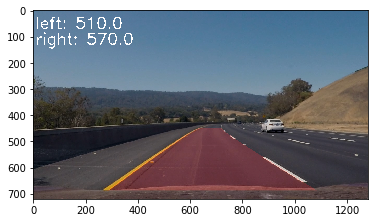

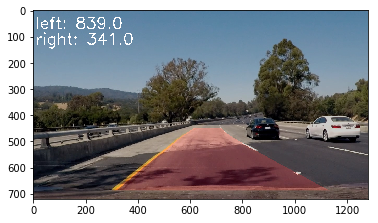

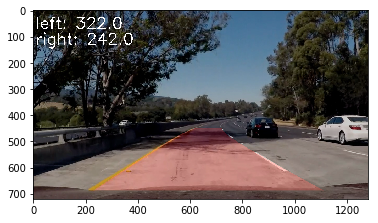

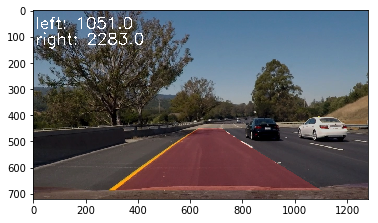

In [222]:
for image in testImages:
    #displayImage(image)
    displayImage(imagePipeline(image))

In [102]:
videoOutput = 'output_images/video.mp4'
clip2 = VideoFileClip('project_video.mp4')
videoWithLines = clip2.fl_image(imagePipeline)
%time videoWithLines.write_videofile(videoOutput, audio=False)

[MoviePy] >>>> Building video output_images/video.mp4
[MoviePy] Writing video output_images/video.mp4


100%|█████████▉| 1260/1261 [03:24<00:00,  6.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/video.mp4 

CPU times: user 3min 37s, sys: 28.9 s, total: 4min 6s
Wall time: 3min 26s


In [103]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(videoOutput))